# Clustering Customers of a Comic Book Store

In this assignment, you will be solving a traditional problem in quantitative marketing: Customer segmentation. Having a properly segmented database is extremely important to define marketing campaigns, as it allows companies to define value-centric actions targeted towards customers of different profiles. While there are several ways we can cluster customers, in this example we will use the [Recency, Frequency and Monetary Value](https://en.wikipedia.org/wiki/RFM_(market_research)), or RFM, paradigm to do so. This way of thinking of customer data reflects the engagement between a customer and a company by reducing their interactions to three values:

- The **Recency** between interactions: The time between two subsequent purchases or between two general interactions between the customer and your organization.

- The **Frequency** of interactions: The raw number of interactions over a predefined time. This can be for example how many times a customer visits your website every month, or how many purchases the customer does at your store, etc.

- The **Monetary Value** of the interactions: The total monetary value (not necessarily positive) of the interactions of the customer with your organization over the same period of time as before.

Additionally, this dataset has a **Cost of Service** variable (which is not included in the MV calculations for this example). It shows how much cost each interaction with the customer brings. This can be useful information as a customer may make purchases of small monetary value, but may spend many hours at the store occupying the service personnel's time. This can mean on average these customers may even end up being a cost to the company! The information comes from a local comic book store, and represents the summary of interactions of the customers with a loyalty card.

In this assignment, we will create a clustering of the customers using these four variables and will create a commercial strategy arising from our results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline

In [2]:
# Uncomment if working in the cloud
#!gdown https://drive.google.com/uc?id=1VL-LjrjgCtGWkDw914MVLj2sEttlL2Uv

## Task 1: Studying the data [10 pts]

Import the data and present the descriptive statistics of all variables. **Written answer: What can you say about the variables you have? Why should you normalize the data?**. Normalize the data so you can create clusters.

In [3]:
# Read the data
df = pd.read_csv('RFM_Assignment_Week11.csv')
df.describe()


,Recency,Frequency,MV,CoS
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,30.116293,17.164128,8806.972152,8805.228492
std,17.742131,29.419952,3391.111080,3285.384316
min,-4.942628,-1.237633,760.115629,944.136187
25%,18.221827,3.710640,8065.394231,9957.361435
50%,28.588186,6.030687,10462.416975,10000.463454
75%,35.880252,9.999136,10608.634596,10041.297949
max,67.258701,102.189321,11139.504803,11054.536104


In [4]:
# df.columns

In [5]:
# Normalize (Standard) and apply to the data
std_pipe = Pipeline([
    ('scale', StandardScaler())
])

df_scl = std_pipe.fit_transform(df)  


**Written answer:** Values of different parameters are in different ranges, especially the values in `MV` and `CoS` are two orders of magnitude bigger than values in `Recency` and `Frequesncy`. We need to scale the values to get equal effect of parameters in our clustering. 

## Task 2: K-Means Clustering and Silhoutte Analysis [30 pts]

Now we can perform the cluster analysis. The single most important question in cluster analysis is to determine the number of clusters that you should create. Following the labs (or [this tutorial](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)), try between 3 and 8 clusters, using a seed of 10, and plot their silouhette analyses (we will plot the clusters themselves in the next question). **Written answer: What is the optimal number of clusters using the silhouette method?**

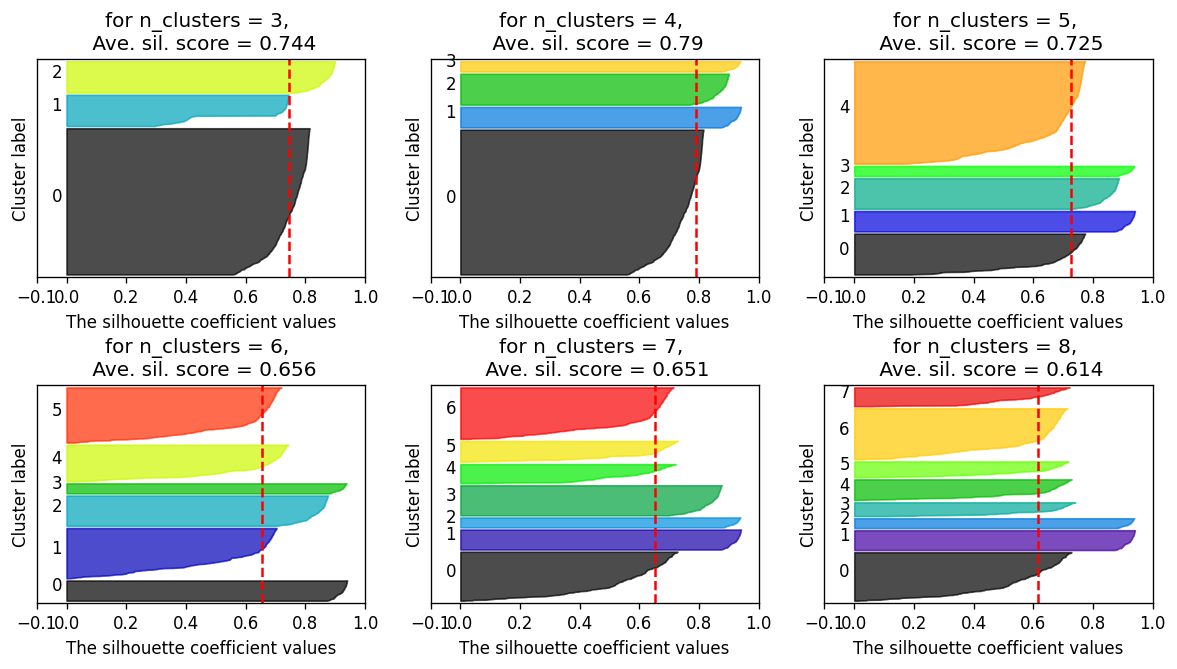

In [6]:
# Your answer here.

fig, ax = plt.subplots(dpi = 120, nrows = 2, ncols=3, figsize=(12,6))
plt.subplots_adjust(hspace = 0.5)
ax = ax.ravel()

range_n_clusters = [3, 4, 5, 6, 7, 8]

for n_clusters,a in zip(range_n_clusters, ax):
    a.set_xlim([-0.1, 1])
    a.set_ylim([0, len(df_scl) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_scl)
    
    silhouette_avg = silhouette_score(df_scl, cluster_labels)
    a.set_title(f'for n_clusters = {n_clusters}, \n Ave. sil. score = {silhouette_avg.round(3)}')
    sample_silhouette_values = silhouette_samples(df_scl, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        a.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        a.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    a.set_xlabel("The silhouette coefficient values")
    a.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    a.axvline(x=silhouette_avg, color="red", linestyle="--")

    a.set_yticks([])  # Clear the yaxis labels / ticks
    a.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
plt.show()

**Written answer:** The silehoutte plot for n_cluster = 3, 4, 5 are a bad pick due to wide fluctuations in the size of the silhouette plots.

between n_cluster = 6,7,8, I think 6 clusters is a suitable choice because the ave. silehoutte value is just 0.005 smaller than the silehoutte score for n_cluster = 7 and except one cluster, the rest are more or less of similar thickness, whereas with n_cluster =7, 8 we have several small groups separated as individual clusters.  

## Task 3: Plotting the clusters [20 pts]

Now we will visualize what we just did. For this we will use a common trick in clustering: use a PCA transform to reduce the data to a few variables (two or three) and plot those. Apply a PCA transform to the data using two components and create a scatterplot, differentiating by using colours the clusters from previous answer using a different colour. **Note the clusters still must be calculated over the unrotated data**. Use only your results from using 3, 4 and 5 clusters. **Written answer: How many clusters would you use considering the results of task 2 and these ones?**

In [7]:
# Your code here. Add as many cells as you need!

PCA_1 = PCA(n_components = 2)


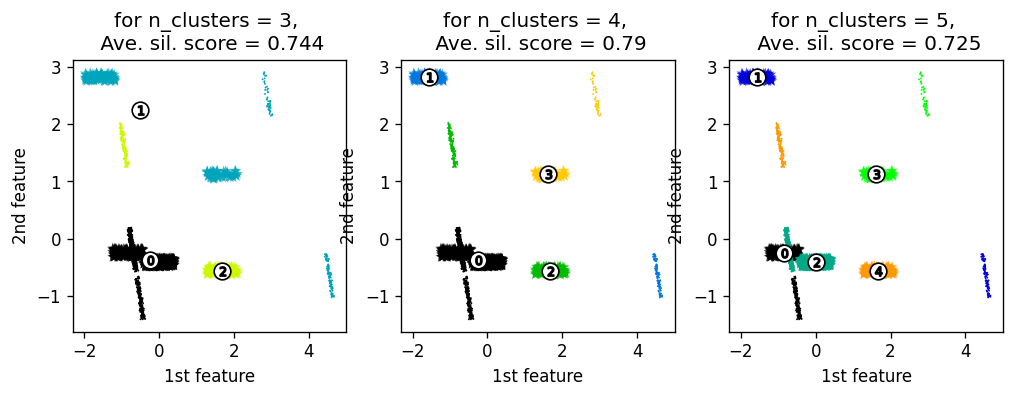

In [8]:
# Your answer here.

fig, ax = plt.subplots(dpi = 120, nrows = 1, ncols=3, figsize=(10,3))
plt.subplots_adjust(hspace = 0.5)
ax = ax.ravel()

range_n_clusters = [3, 4, 5]

for n_clusters,a in zip(range_n_clusters, ax):
    
    clusterer = KMeans(n_clusters = n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_scl)
       
    silhouette_avg = silhouette_score(df_scl, cluster_labels)
    a.set_title(f'for n_clusters = {n_clusters}, \n Ave. sil. score = {silhouette_avg.round(3)}')
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    # Plotting data before rotation
    a.scatter(df_scl[:, 0], df_scl[:, 1], marker='*', s=50, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Plotting data after rotation
    df_PCA = PCA_1.fit_transform(df_scl)
    a.scatter(df_PCA[:, 0], df_PCA[:, 1], marker='.', s=5, lw=0, alpha=1,
                c=colors, edgecolor='r')
    
#     Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    a.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=100, edgecolor='k')

    for i, c in enumerate(centers):
        a.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=30, edgecolor='k')

    a.set_xlabel("1st feature")
    a.set_ylabel("2nd feature")

    
plt.show()

**Written answer** We have shown the data points before the PCA application with stars that their aggregation make some thick horizontal lines. After applying PCA, data is projected on an almost vertical axis. The data for the same cluster is shown with the same color. when n_cluster = 3, we have two far apart patches in turquoise color grouped in the same cluster, that can not be correct.

It seem that n_cluster = 4, 5 both are differenciating different groups properly, but n_cluster=5 has smaller Ave. Sil. score and more similar width for different cluster's silhouette graph. Based on what I see in the scatter plots, there are not more than 5 groups to cluster to use higher n_clusters, thus I pick n_cluster = 5 for this data. 

## Task 4: Deploying the model. [20 pts]

The objective of any cluster analysis over customer data is to create a reasonable segmentation of your customers. Using the number of clusters you have decided in Task 3 and a table of the averages per variable for each cluster, name the different clusters and think what would a company would do with a customer in that cluster. (*Hint: For example a clusters with high frequency, low recency, and low monetary value are desirable customers for whom it would be a good plan to try to increase their monetary value while keeping their high engagement. You could name them "Diamonds in the rough". [Pandas' `groupby`](https://stackoverflow.com/questions/30328646/python-pandas-group-by-in-group-by-and-average) can probably help.*)

In [9]:
# Your code here.
clusterer = KMeans(n_clusters = 5, random_state=10)

cluster_labels = clusterer.fit_predict(df_scl)

scl_dataframe = pd.DataFrame(data = df_scl, columns = df.columns) 
scl_dataframe['cluster_label_scaled'] = cluster_labels 

# scl_dataframe.groupby(['Recency']).mean().groupby(['cluster_name_scaled']).mean()
scl_dataframe.groupby(['cluster_label_scaled']).mean()


,Recency,Frequency,MV,CoS
cluster_label_scaled,,,,
0,-0.857400,-0.243353,0.646002,0.363679
1,-1.576063,2.815243,-2.258159,-2.375193
2,-0.005584,-0.411666,0.497971,0.363902
3,1.614325,1.122078,-2.339649,-2.349483
4,1.674413,-0.554165,-0.235917,0.668710


**Written answer: (note this answer will be much longer than usual as you need to make an argument for every cluster)**

(cluster with MV=0.497971, Cos=0.363902): This group has almost zero recency, but compare to the `frequency` score it can be interprreted as their interest is increasing. Comparing their `monetary value` with `costs`, i.e. `MV/CoS=1.36` shows that their contribution is positive for the company and they have the potential of envolving more.

(cluster with MV=-2.258159, CoS=-2.375193): This group has low `monetary values` at the same time doesn't impose much cost to the company (low `CoS`) `MV/Cos = 0.95`. Their high `frequency` score and low `recency` can be interpreted as they were more interested in visiting the store in past. It might be because of shortage of communication with sales persons (low `CoS`). Finding methods of involving them more with the products and hearing more about their preferences, might result in an improvement in their contribution.

(cluster with MV=-2.339649, CoS=-2.349483): This group is similar to the previous group except they get higher score in the `recency` factor compared to the `frequency` that can show their increasing interest to the products. Higher comunication of sale persons might help with encouraging them ro shop. 

(cluster with MV=-0.235917, CoS=0.668710): The rate of visit (`recency` score) in this group has a sharp raise compared to the past (`frequency` score). The cost of this group is pretty high for the company compared to their amount of purchace.  

(cluster with MV=0.646002, Cos = 0.363679): This cluster describes customers with the highest average of `monetary values` and in respect to the cost they have for the company per visit, they are the most efficient group of customers for the company, `MV/CoS = 1.77`.  Considering the lower value of `recency` compared to the `frequency`, it seems they are loosing their interset compared to the past, but they have a potential of purchacing more providing some of the past topics be back to the market. 

## Task 5: Hierarchical clustering comparison [20 pts]

Now repeat the clustering process using a complete linkage hierarchical clustering with cosine affinity, using the same number of clusters as Task 4. Using the PCA transform you calculated in Task 3, create a scatterplot differentiating the obtained clusters using different colours. **Written answer: What can you say about the new clustering you obtained? Why does this happen? When would you say it is a good idea to use this configuration?** 

Text(0, 0.5, '2nd feature')

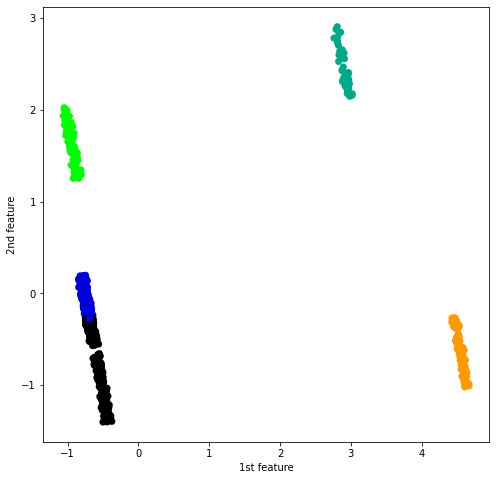

In [10]:
# Your code here
c1_pipe = Pipeline([
    ('aggc1', AgglomerativeClustering(n_clusters = 5,
                                      affinity = 'cosine', linkage='complete'))
])

PCA_1 = PCA(n_components = 2)


cluster_labels = c1_pipe.fit_predict(df_scl)

df_PCA = PCA_1.fit_transform(df_scl)


fig, ax = plt.subplots(figsize=(8,8))

colors = cm.nipy_spectral(cluster_labels.astype(float) / 5)

ax.scatter(df_PCA[:, 0], df_PCA[:, 1], marker='o', s=50, lw=0, alpha=1,
            c=colors, edgecolor='r')

ax.set_xlabel("1st feature")
ax.set_ylabel("2nd feature")


**Written answer:** We see that a patch of data points is divided in two parts and each part labeled with different clusters. This problem occurs from using affinity of `cosine` with linkage `complete`. If we change either of them this problem is resolved, i.e. using linkage single or averaged, or using 'l1' or 'l2' for affinity.
`cosine` affinity is usually used for data points as vectors.